In this demo, we follow [Tyler Sloan](https://quorumetrix.blogspot.com/2018/06/visualizing-lidar-data-with-datashader.html)'s walkthrough where he downloads LiDAR data from the City of Montreal (featuring the 1976 Olympic Stadium) and visualizes it ([original notebook here](https://github.com/tsloan1377/montreal_open_data/blob/master/lidar_datashader_blog.ipynb)).

We're going to grab some data from Macodrum Library.


## Imports

In [ ]:
!pip install imageio
!pip install laspy
!pip install datashader
!pip install lazrs
!pip install rasterio

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import imageio
import laspy  # Modern laspy import
import datashader as ds
import datashader.transfer_functions as tf
from matplotlib import cm

We already downloaded the tiles around the [site of Avebury](https://en.wikipedia.org/wiki/Avebury) from the [data.gov.uk](https://environment.data.gov.uk/ds/survey/index.jsp#/survey?grid=SU17) service. These tiles are in the [aveburytiles](/aveburytiles) folder. Unzip them, and explore! Try changing the various `class` parameters in the visualizations. Reuse code blocks

# observation Sept 1

Hi everyone!

## Load LIDAR file with LasPy

Grab some LIDAR data courtesy of our Library. Go to [the City of Ottawa LiDAR indices](https://carleton-u.maps.arcgis.com/apps/PublicInformation/index.html?appid=bb86c9b09c7f4e03a061badaf7464245). You'll have to agree to the terms of use, but that's ok. Then, click a square you're interested in (Pinhey's Point, on the Ottawa River near Dunrobin is a neat one with a ruined manor house). Then click on 'Direct Download LAS file'. This will download a zip file to your machine. Unzip it (windows users! Right-click and hit 'extract all'!) and then drag and drop it into the week-three folder of your workbench.

I selected the square containing [Pinhey's Point](https://pinheyspoint.ca/visit-pinheys-point/). I unzipped that, and I then moved the resulting file, 3475033.las to the week-three folder.

![](which-square.png)

In [49]:

sample_data = '3475033.las'
export_path = 'export/'

In [50]:
# Read the LAS/LAZ file using modern laspy
las = laspy.read(sample_data)

# Access point data
points = las.points
x = las.x
y = las.y
z = las.z

# If you need other attributes, they're available as:
# intensity = las.intensity
# classification = las.classification
# return_number = las.return_number
# etc.

print(f"Number of points: {len(las.points)}")
print(f"Point format: {las.header.point_format}")
print(f"Available dimensions: {list(las.point_format.dimension_names)}")

Number of points: 3733328
Point format: <PointFormat(1, 0 bytes of extra dims)>
Available dimensions: ['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'gps_time']


In [51]:
# Check what type of data you're getting

x_data = np.array(las.x)
y_data = np.array(las.y)
z_data = np.array(las.z)
class_data = np.array(las.classification)
    
print(f"X data shape: {x_data.shape}")
print(f"Y data shape: {y_data.shape}")
print(f"Z data shape: {z_data.shape}")
print(f"Class data shape: {class_data.shape}")
   


# Create the DataFrame once you have the arrays
df = pd.DataFrame({
    'X': x_data,
    'Y': y_data,
    'Z': z_data,
    'class': class_data
})

# Basic class distribution
print("Class distribution:")
print(df['class'].value_counts().sort_index())
print()

X data shape: (3733328,)
Y data shape: (3733328,)
Z data shape: (3733328,)
Class data shape: (3733328,)
Class distribution:
class
2     1739360
3     1092775
5      767526
7       25887
9       92885
10       1087
11      13808
Name: count, dtype: int64



In [52]:
# Basic class distribution
print("Class distribution:")
print(df['class'].value_counts().sort_index())
print()

# Get unique classes
unique_classes = sorted(df['class'].unique())
print(f"Unique classes found: {unique_classes}")
print()

# Standard LIDAR classification meanings (ASPRS Point Cloud Classification)
lidar_classifications = {
    0: "Never classified",
    1: "Unassigned", 
    2: "Ground",
    3: "Low vegetation (< 0.5m)",
    4: "Medium vegetation (0.5-2m)", 
    5: "High vegetation (> 2m)",
    6: "Building",
    7: "Low point / Noise",
    8: "Reserved (formerly Model Key-point)",
    9: "Water",
    10: "Rail",
    11: "Road surface",
    12: "Reserved (formerly Overlap)",
    13: "Wire - Guard",
    14: "Wire - Conductor", 
    15: "Transmission tower",
    16: "Wire - Connector",
    17: "Bridge deck",
    18: "High noise",
    19: "Overhead structure",
    20: "Ignored ground",
    21: "Snow",
    22: "Temporal exclusion"
}

# Show what each class in your data likely represents
print("Classification interpretation for your data:")
print("-" * 50)
for class_num in unique_classes:
    count = (df['class'] == class_num).sum()
    percentage = (count / len(df)) * 100
    meaning = lidar_classifications.get(class_num, "Unknown/Custom classification")
    print(f"Class {class_num:2d}: {meaning}")
    print(f"         Count: {count:,} points ({percentage:.1f}%)")
    print()

# Summary statistics by class
print("\nElevation statistics by class:")
print("-" * 40)
elevation_stats = df.groupby('class')['Z'].agg(['count', 'mean', 'std', 'min', 'max']).round(2)
print(elevation_stats)

# Show which classes dominate your dataset
print(f"\nDataset summary:")
print(f"Total points: {len(df):,}")
print(f"Elevation range: {df['Z'].min():.2f}m to {df['Z'].max():.2f}m")
print(f"Most common class: {df['class'].mode().iloc[0]} ({lidar_classifications.get(df['class'].mode().iloc[0], 'Unknown')})")

Class distribution:
class
2     1739360
3     1092775
5      767526
7       25887
9       92885
10       1087
11      13808
Name: count, dtype: int64

Unique classes found: [np.uint8(2), np.uint8(3), np.uint8(5), np.uint8(7), np.uint8(9), np.uint8(10), np.uint8(11)]

Classification interpretation for your data:
--------------------------------------------------
Class  2: Ground
         Count: 1,739,360 points (46.6%)

Class  3: Low vegetation (< 0.5m)
         Count: 1,092,775 points (29.3%)

Class  5: High vegetation (> 2m)
         Count: 767,526 points (20.6%)

Class  7: Low point / Noise
         Count: 25,887 points (0.7%)

Class  9: Water
         Count: 92,885 points (2.5%)

Class 10: Rail
         Count: 1,087 points (0.0%)

Class 11: Road surface
         Count: 13,808 points (0.4%)


Elevation statistics by class:
----------------------------------------
         count   mean    std    min     max
class                                      
2      1739360  82.31   8.72  58.2

## Plot the tile using datashader

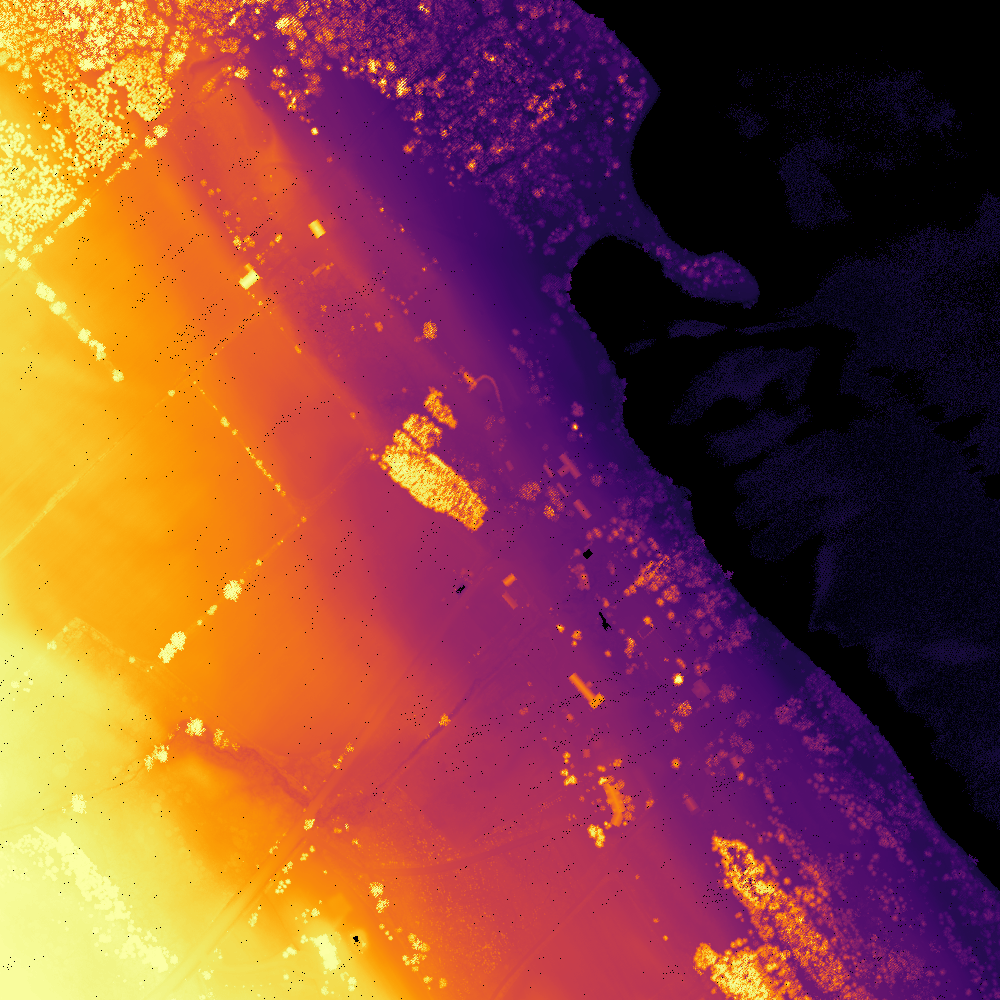

In [53]:
# all the data
cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(df, 'X', 'Y', ds.mean('Z'))
img = tf.shade(agg)#, cmap=['lightblue', 'darkblue'], how='log')
tf.set_background(tf.shade(agg, cmap=cm.inferno),"black")

Or you can separate it out by different kinds of data; do you see where you might change the code?

Ground points (class 2): 1739360
Vegetation points (class 3): 1092775
Other points (class 8): 0


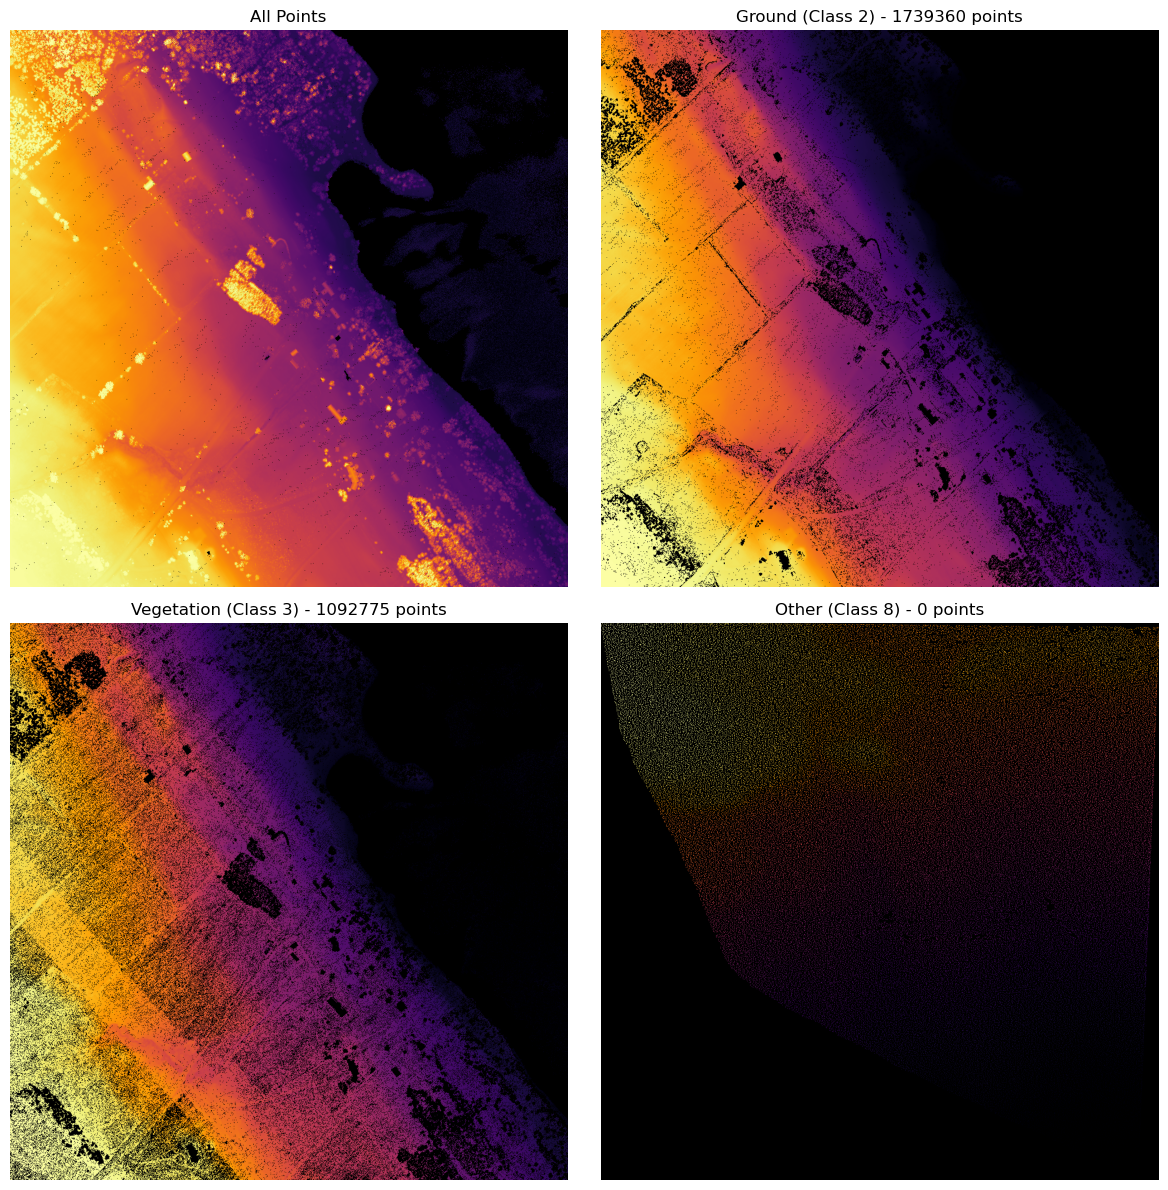

In [54]:
import datashader as ds
import datashader.transfer_functions as tf
from matplotlib import cm
import matplotlib.pyplot as plt

# All points visualization
cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(df, 'X', 'Y', ds.mean('Z'))
img = tf.shade(agg, cmap=cm.inferno)
all_points_img = tf.set_background(img, "black")

# Ground points (class 2)
ground_df = df.loc[df['class'] == 2]
print(f"Ground points (class 2): {len(ground_df)}")

if len(ground_df) > 0:
    cvs = ds.Canvas(plot_width=1000, plot_height=1000)
    agg = cvs.points(ground_df, 'X', 'Y', ds.mean('Z'))
    img = tf.shade(agg, cmap=cm.inferno)
    ground_img = tf.set_background(img, "black")

# Vegetation (class 3 in your data)
veg_df = df.loc[df['class'] == 3]
print(f"Vegetation points (class 3): {len(veg_df)}")

if len(veg_df) > 0:
    cvs = ds.Canvas(plot_width=1000, plot_height=1000)
    agg = cvs.points(veg_df, 'X', 'Y', ds.mean('Z'))
    img = tf.shade(agg, cmap=cm.inferno)
    veg_img = tf.set_background(img, "black")

# Other class (class 8 in your data)
other_df = df.loc[df['class'] == 8]
print(f"Other points (class 8): {len(other_df)}")

if len(other_df) > 0:
    cvs = ds.Canvas(plot_width=1000, plot_height=1000)
    agg = cvs.points(other_df, 'X', 'Y', ds.mean('Z'))
    img = tf.shade(agg, cmap=cm.inferno)
    other_img = tf.set_background(img, "black")

# Display the results
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# All points
axes[0,0].imshow(all_points_img.to_pil())
axes[0,0].set_title('All Points')
axes[0,0].axis('off')

# Ground
if 'ground_img' in locals():
    axes[0,1].imshow(ground_img.to_pil())
    axes[0,1].set_title(f'Ground (Class 2) - {len(ground_df)} points')
else:
    axes[0,1].text(0.5, 0.5, 'No ground points', ha='center', va='center')
    axes[0,1].set_title('Ground (Class 2)')
axes[0,1].axis('off')

# Vegetation
if 'veg_img' in locals():
    axes[1,0].imshow(veg_img.to_pil())
    axes[1,0].set_title(f'Vegetation (Class 3) - {len(veg_df)} points')
else:
    axes[1,0].text(0.5, 0.5, 'No vegetation points', ha='center', va='center')
    axes[1,0].set_title('Vegetation (Class 3)')
axes[1,0].axis('off')

# Other
if 'other_img' in locals():
    axes[1,1].imshow(other_img.to_pil())
    axes[1,1].set_title(f'Other (Class 8) - {len(other_df)} points')
else:
    axes[1,1].text(0.5, 0.5, 'No other points', ha='center', va='center')
    axes[1,1].set_title('Other (Class 8)')
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

## Create a 3D surface visualization

The code below is computationally intensive; it will take some time. The results will be written to a new folder called 'export'; you can open that folder by clicking on the jupyter logo at top and then clicking on the 'export' folder.

You will know the code is finished when the `[*]` at the left of the code block changes to a number.

In [56]:
# 
X = df['X']
Y = df['Y']
Z = df['Z']

# Downsample x and y
ds_factor = 500
ds_x = X[::ds_factor] 
ds_y = Y[::ds_factor] 
ds_z = Z[::ds_factor] 

##### Export the gif
frames = []
identifier = 'bigO_tile_downsample_' + str(ds_factor) + 'x_surface_lidar'  

if not os.path.exists(export_path):
    os.makedirs(export_path)

fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111, projection='3d')

# Plot the surface.
surf = ax.plot_trisurf(ds_x, ds_y, ds_z, cmap=cm.inferno,
                       linewidth=0, antialiased=False)

for angle in range(0, 360):
    ax.view_init(60, angle) # Higher angle than usually used of 30.
    ax.set_axis_off()

    # Draw the figure
    fig.canvas.draw()

    # Convert to numpy array, and append to list
    np_fig = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    np_fig = np_fig.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(np_fig)

imageio.mimsave(export_path + identifier + '.gif', frames)

/var/folders/0k/0xq4y1q92k163n98ldpb168c0000gn/T/ipykernel_14627/3081828152.py:34: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  np_fig = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
/var/folders/0k/0xq4y1q92k163n98ldpb168c0000gn/T/ipykernel_14627/3081828152.py:34: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  np_fig = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')


## Export the data so that it can be used as a DEM in a GIS

The following cell will create a digital elevation model that could be used in the [[r-for-gis.ipynb]] notebook.

In [60]:
import rasterio
from rasterio.transform import from_bounds
import numpy as np
from scipy.interpolate import griddata

def create_dem_from_lidar(df, output_file, resolution=1.0, method='linear'):
    """
    Convert LIDAR point cloud to DEM raster
    
    Parameters:
    df: DataFrame with X, Y, Z columns
    output_file: Output GeoTIFF filename
    resolution: Grid cell size in meters
    method: Interpolation method ('linear', 'nearest', 'cubic')
    """
    
    # Filter to ground points only (class 2) for a proper DEM
    ground_points = df[df['class'] == 2].copy()
    
    if len(ground_points) == 0:
        print("No ground points found, using all points")
        ground_points = df.copy()
    
    print(f"Using {len(ground_points):,} points for DEM creation")
    
    # Get bounds
    x_min, x_max = ground_points['X'].min(), ground_points['X'].max()
    y_min, y_max = ground_points['Y'].min(), ground_points['Y'].max()
    
    print(f"Bounds: X({x_min:.2f}, {x_max:.2f}), Y({y_min:.2f}, {y_max:.2f})")
    
    # Create grid
    x_coords = np.arange(x_min, x_max + resolution, resolution)
    y_coords = np.arange(y_max, y_min - resolution, -resolution)  # Reverse for raster
    
    xi, yi = np.meshgrid(x_coords, y_coords)
    
    print(f"Grid size: {len(x_coords)} x {len(y_coords)} = {len(x_coords) * len(y_coords):,} cells")
    
    # Interpolate elevation values
    print("Interpolating elevation values...")
    points = np.column_stack((ground_points['X'].values, ground_points['Y'].values))
    values = ground_points['Z'].values
    
    zi = griddata(points, values, (xi, yi), method=method, fill_value=np.nan)
    
    # Create raster transform
    transform = from_bounds(x_min, y_min, x_max, y_max, zi.shape[1], zi.shape[0])
    
    # Write to GeoTIFF
    with rasterio.open(
        output_file,
        'w',
        driver='GTiff',
        height=zi.shape[0],
        width=zi.shape[1],
        count=1,
        dtype=zi.dtype,
        crs='EPSG:4326',  # You may need to adjust this based on your data's CRS
        transform=transform,
        compress='lzw'
    ) as dst:
        dst.write(zi, 1)
    
    print(f"DEM saved as: {output_file}")
    print(f"Elevation range: {np.nanmin(zi):.2f}m to {np.nanmax(zi):.2f}m")
    
    return zi

# Create the DEM
dem_array = create_dem_from_lidar(df, 'lidar_dem.tif', resolution=1.0)

# Visualize the result
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.imshow(dem_array, cmap='terrain', aspect='equal')
plt.colorbar(label='Elevation (m)')
plt.title('LIDAR-derived DEM')
plt.show()

Using 1,739,360 points for DEM creation
Bounds: X(347000.00, 347999.99), Y(5033000.00, 5033999.99)
Grid size: 1001 x 1001 = 1,002,001 cells
Interpolating elevation values...
DEM saved as: lidar_dem.tif
Elevation range: 58.31m to 96.01m
